## Import Library

In [1]:
import os
import cv2
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import random



print(os.listdir("cs-ioc5008-hw1/dataset/dataset/train/"))  # Directory where training data folders are

['bedroom', 'coast', 'forest', 'highway', 'insidecity', 'kitchen', 'livingroom', 'mountain', 'office', 'opencountry', 'street', 'suburb', 'tallbuilding']


## Prepare Traning Data

In [2]:
def get_images(directory):
    Images = []  # List to store all training images
    Labels = []  # List to store 13 scenes labels
    label = 0  # To give each label a specific number
    
    for labels in os.listdir(directory):  # Main directory where each class label is present as folder name
        if labels == 'bedroom':  # Folder contain each scene images get the 'Specific' class label number
            label = 0
        elif labels == 'coast':
            label = 1
        elif labels == 'forest':
            label = 2
        elif labels == 'highway':
            label = 3
        elif labels == 'insidecity':
            label = 4
        elif labels == 'kitchen':
            label = 5
        elif labels == 'livingroom':
            label = 6
        elif labels == 'mountain':
            label = 7
        elif labels == 'office':
            label = 8
        elif labels == 'opencountry':
            label = 9
        elif labels == 'street':
            label = 10
        elif labels == 'suburb':
            label = 11
        elif labels == 'tallbuilding':
            label = 12
        
        for image_file in os.listdir(directory+labels):  # Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file)  # Reading the image (OpenCV)
            image = cv2.resize(image,(224,224))  # Resize the image, Some images are different sizes
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels)  # Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {
        0:'bedroom',
        1:'coast',
        2:'forest',
        3:'highway',
        4:'insidecity',
        5:'kitchen',
        6:'livingroom',
        7:'mountain',
        8:'office',
        9:'opencountry',
        10:'street',
        11:'suburb',
        12:'tallbuilding'
    }
    
    return labels[class_code]

In [3]:
Images, Labels = get_images("cs-ioc5008-hw1/dataset/dataset/train/")  # Extract the training images from the folders.

Images = np.array(Images) # Converting the list of images to numpy array.
Labels = np.array(Labels)

Images = np.array(Images, dtype=np.float32) # Converting the list of images to numpy array.
Images = Images / 255.0  # Normalization
Labels = np.array(Labels)

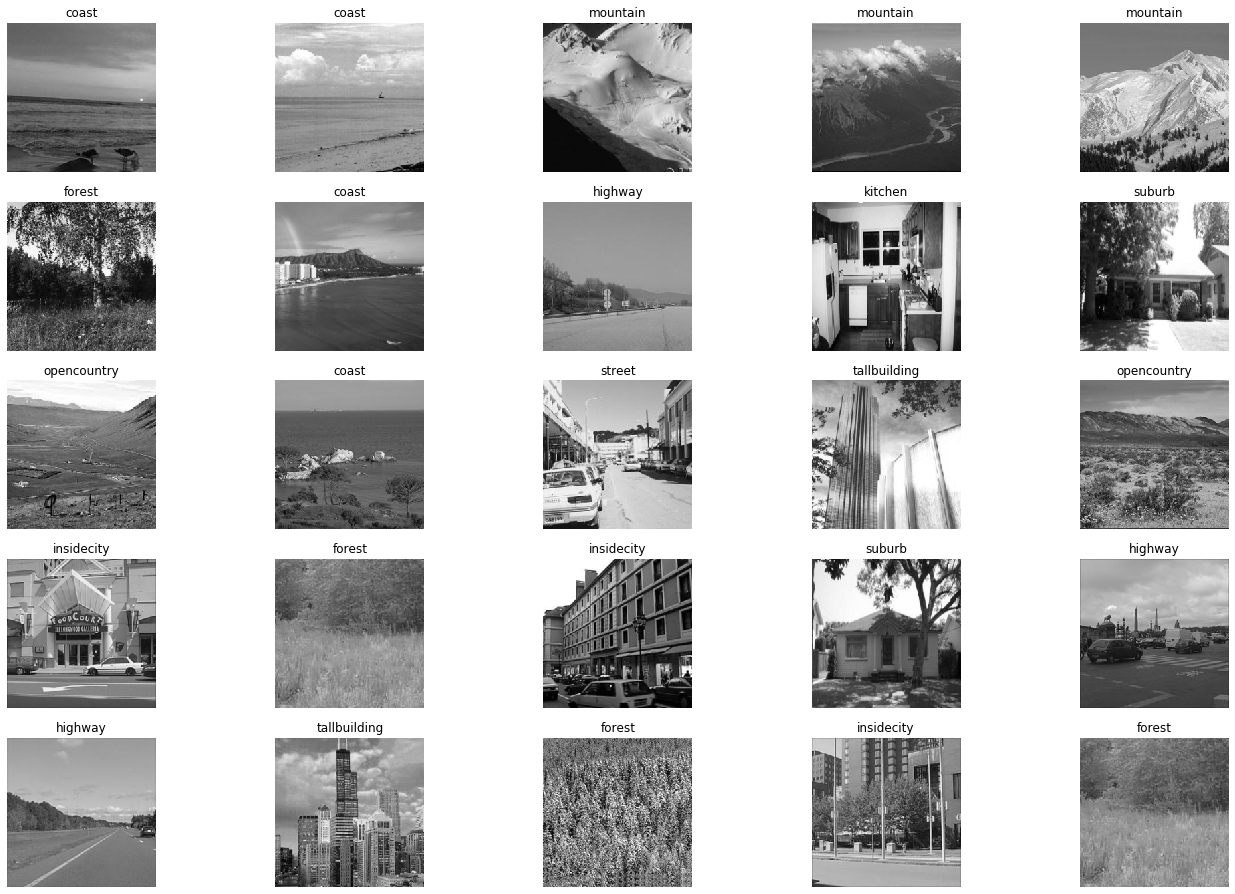

In [4]:
f, ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = random.randint(0, len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')
plt.savefig('gray.png')

## Build Model (VGG16)

In [5]:
# Hyperparameters
batch_size = 64  # Training batch size
num_classes = 13  # Classes in dataset
num_epochs = 35   # Epochs for training   
lr = 3e-4  # Learning rate
lr_weight_decay = 0 # Learning weight decay

In [6]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

# Transfer Learning from VGG16 architecture
# Without fully-connected layers
# define input shape as (224,224,3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Define our own fully-connected layers & output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation



model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
# Training with the final custom-made layers
for layer in model.layers[:-5]:
    layer.trainable =False
for layer in model.layers[-5:]:
    layer.trainable=True
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Callbacks
- Early Stop
- Learning Rate Reduction
- Model Check Point

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=10)

# Reduce the learning rate when accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# To get the best performance model
model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

callbacks = [earlystop, learning_rate_reduction, model_ckpt]

## Traning & Validation Generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions

# preprocessing image and divide validaiton set
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, validation_split=0.08)

train_generator=train_datagen.flow_from_directory('cs-ioc5008-hw1/dataset/dataset/train/',
                                                 target_size=(224,224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')


validation_generator = train_datagen.flow_from_directory('cs-ioc5008-hw1/dataset/dataset/train/',
                                                 target_size=(224,224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 subset='validation')

Found 2601 images belonging to 13 classes.
Found 218 images belonging to 13 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

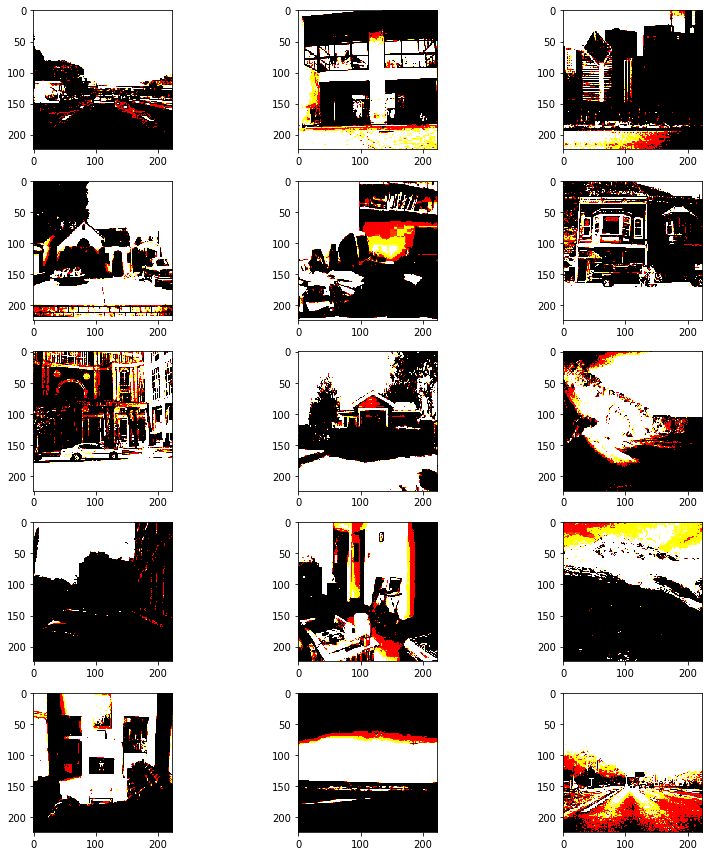

In [10]:
# Visualize the preprocessing images

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model (VGG16)

In [11]:
from keras import optimizers
# Use default adam optimizer (learning rate=1e-3, decay=0)
# Loss function: categorical cross entropy
# Evaluation: Accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


step_size_train = train_generator.n // train_generator.batch_size
step_size_val = validation_generator.n // validation_generator.batch_size

history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=num_epochs, callbacks=callbacks)

Epoch 1/35
40/40 [==============================] - 26s 662ms/step - loss: 1.6096 - acc: 0.5815 - val_loss: 0.4155 - val_acc: 0.8698
Epoch 2/35
40/40 [==============================] - 19s 487ms/step - loss: 0.5497 - acc: 0.8191 - val_loss: 0.2946 - val_acc: 0.9351
Epoch 3/35
40/40 [==============================] - 18s 447ms/step - loss: 0.3834 - acc: 0.8800 - val_loss: 0.4596 - val_acc: 0.8247
Epoch 4/35
40/40 [==============================] - 18s 450ms/step - loss: 0.2950 - acc: 0.9001 - val_loss: 0.2198 - val_acc: 0.9286

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/35
40/40 [==============================] - 18s 454ms/step - loss: 0.2296 - acc: 0.9230 - val_loss: 0.2345 - val_acc: 0.9271
Epoch 6/35
40/40 [==============================] - 18s 449ms/step - loss: 0.1887 - acc: 0.9318 - val_loss: 0.2588 - val_acc: 0.8896

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/35
40/40 [======================

In [12]:
model.load_weights("./tmp.h5")

## Evaluation

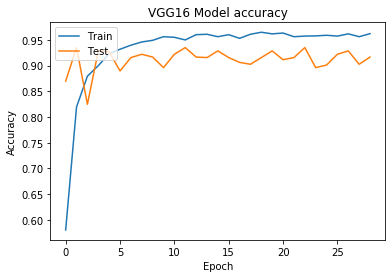

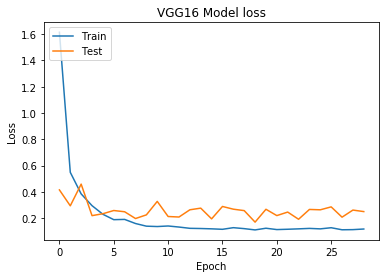

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG16 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Build Model (ResNet50)

In [14]:
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout


base_model_2 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

x = base_model_2.output
x = GlobalAveragePooling2D()(x)


preds = Dense(13, activation='softmax')(x)

model_2 = Model(inputs=base_model_2.input, outputs=preds)
model_2.summary()

C:\Users\tony8\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
for layer in model_2.layers[:-2]:
    layer.trainable = False
for layer in model_2.layers[-2:]:
    layer.trainable = True
    
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Traning & Validation Generator

In [16]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, validation_split=0.08)

train_generator=train_datagen.flow_from_directory('cs-ioc5008-hw1/dataset/dataset/train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')


validation_generator = train_datagen.flow_from_directory('cs-ioc5008-hw1/dataset/dataset/train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 subset='validation')

Found 2601 images belonging to 13 classes.
Found 218 images belonging to 13 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

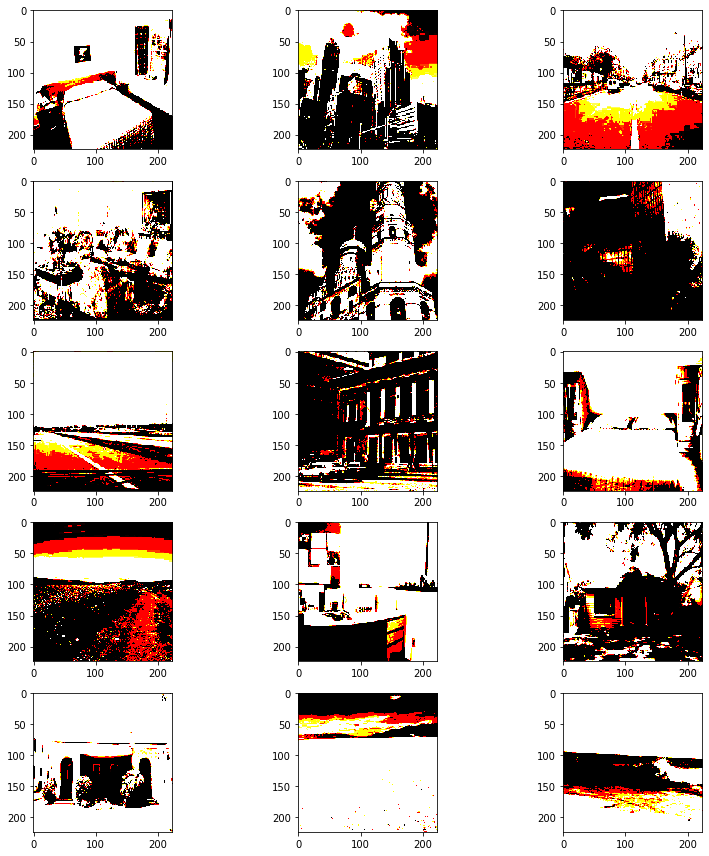

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model (ResNet50)

In [18]:
from keras import optimizers

# Use adam optimizer with lr=1e-3
# Loss function: categorical cross entropy
# Evaluation: Accuracy
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train = train_generator.n // train_generator.batch_size
step_size_val = validation_generator.n // validation_generator.batch_size

history_2 = model_2.fit_generator(generator = train_generator, steps_per_epoch = step_size_train,
                              validation_data = validation_generator, validation_steps = step_size_val,
                              epochs=num_epochs, callbacks=callbacks)

Epoch 1/35
40/40 [==============================] - 19s 467ms/step - loss: 1.1864 - acc: 0.6195 - val_loss: 0.7283 - val_acc: 0.7344
Epoch 2/35
40/40 [==============================] - 14s 355ms/step - loss: 0.4031 - acc: 0.8777 - val_loss: 0.5282 - val_acc: 0.7987
Epoch 3/35
40/40 [==============================] - 14s 341ms/step - loss: 0.2772 - acc: 0.9231 - val_loss: 0.5319 - val_acc: 0.8052
Epoch 4/35
40/40 [==============================] - 14s 344ms/step - loss: 0.2085 - acc: 0.9384 - val_loss: 0.4594 - val_acc: 0.8117
Epoch 5/35
40/40 [==============================] - 14s 350ms/step - loss: 0.1914 - acc: 0.9476 - val_loss: 0.4215 - val_acc: 0.8229
Epoch 6/35
40/40 [==============================] - 14s 342ms/step - loss: 0.1517 - acc: 0.9625 - val_loss: 0.5024 - val_acc: 0.7987
Epoch 7/35
40/40 [==============================] - 14s 344ms/step - loss: 0.1386 - acc: 0.9650 - val_loss: 0.5244 - val_acc: 0.8052

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000500000

## Evaluation

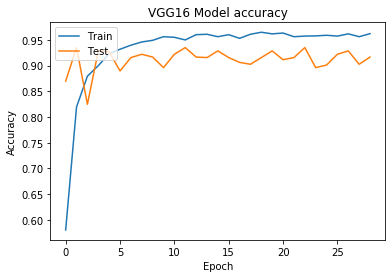

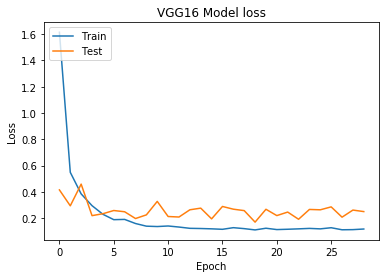

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG16 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prepare Testing Data

In [20]:
def get_test_images(directory):
    Images = []
    names = []
   
    for image_file in os.listdir(directory): #Extracting the file name of the image from Class Label folder
        image = cv2.imread(directory+r'/'+image_file) #Reading the image (OpenCV)
        image = cv2.resize(image,(224,224)) #Resize the image, Some images are different sizes
        Images.append(image)
        names.append(image_file)

    return Images, names

In [21]:
test_images, names = get_test_images("cs-ioc5008-hw1/dataset/dataset/test/")
test_images = np.array(test_images)

## Predict

In [22]:
predict = (model.predict(test_images)*0.5 + model_2.predict(test_images)*0.5).argmax(-1)

In [23]:
dic = {0:'bedroom',
       1:'coast',
       2:'forest',
       3:'highway',
       4:'insidecity',
       5:'kitchen',
       6:'livingroom',
       7:'mountain',
       8:'office',
       9:'opencountry',
       10:'street',
       11:'suburb',
       12:'tallbuilding'
      }

filenames = []
for image_file in os.listdir("cs-ioc5008-hw1/dataset/dataset/test/"): #Extracting the file name of the image from Class Label folder
    filenames.append(image_file.split('.')[0])

df = pd.DataFrame({
    'id': filenames,
    'label': [dic[num] for num in predict]
})

In [24]:
np.unique([dic[num] for num in predict])

array(['bedroom', 'coast', 'forest', 'highway', 'insidecity', 'kitchen',
       'livingroom', 'mountain', 'office', 'opencountry', 'street',
       'suburb', 'tallbuilding'], dtype='<U12')

In [25]:
df.head()

,id,label
0,image_0000,highway
1,image_0001,bedroom
2,image_0002,suburb
3,image_0003,bedroom
4,image_0004,tallbuilding


In [26]:
df.to_csv("hw1_15.csv", header=["id", "label"], index=False) # submission format